# ロジスティック回帰に対するラプラス近似

「Juliaで作って学ぶベイズ統計学」P.184 参照

In [1]:
using Distributions
using Plots
using ForwardDiff
using LinearAlgebra

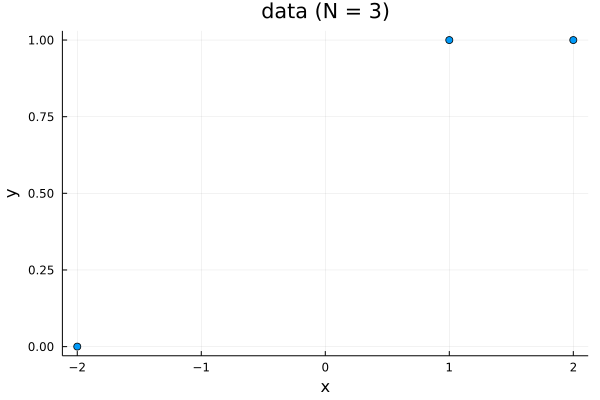

In [2]:
X_obs = [
    -2.0
    1.0
    2.0
]

Y_obs = Bool.([0, 1, 1])


scatter(X_obs, Y_obs, xlab="x", ylab="y", label=:none, title="data (N = $(length(X_obs)))")

In [3]:
# シグモイド関数
sig(x) = 1 / (1 + exp(-x))

# 事前分布の設定
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0

# 対数同時分布
log_joint(w, X, Y, μ₁, σ₁, μ₂, σ₂) =
    logpdf(Normal(μ₁, σ₁), w[1]) +
    logpdf(Normal(μ₂, σ₂), w[2]) +
    sum(logpdf.(Bernoulli.(sig.(w[1] * X_obs .+ w[2])), Y_obs))

# 非正規化対数事後分布
params = (X_obs, Y_obs, μ₁, σ₁, μ₂, σ₂)
ulp(w) = log_joint(w, params...)

# 多次元の勾配法
function gradient_method(f, x_init, η, maxiter)
    x_seq = Array{typeof(x_init[1]), 2}(undef, length(x_init), maxiter)
    g(x) = ForwardDiff.gradient(f, x)
    x_seq[:, 1] = x_init
    for i in 2:maxiter
        x_seq[:, i] = x_seq[:, i-1] + η * g(x_seq[:, i-1])
    end
    x_seq
end

# 最適化のラッパー関数の定義
function inference_wrapper_gd(log_joint, params, w_init, η, maxiter)
    ulp(w) = log_joint(w, params...)
    w_seq = gradient_method(ulp, w_init, η, maxiter)
    w_seq
end

# 最適化パラメータ
w_init = [0.0, 0.0]
maxiter = 2000
η = 0.1

# 最適化の実行
w_seq = inference_wrapper_gd(log_joint, params, w_init, η, maxiter)

2×2000 Matrix{Float64}:
 0.0  0.25  0.443351   0.596734  …  3.05148  3.05148  3.05148  3.05148
 0.0  0.05  0.0901561  0.123311     1.05601  1.05601  1.05601  1.05601

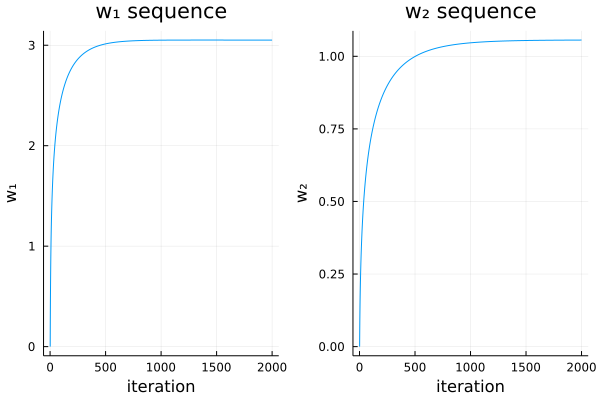

In [4]:
# 勾配法の過程を可視化
plot(
    plot(w_seq[1, :], xlab="iteration", ylab="w₁", title="w₁ sequence", label=:none),
    plot(w_seq[2, :], xlab="iteration", ylab="w₂", title="w₂ sequence", label=:none)
)

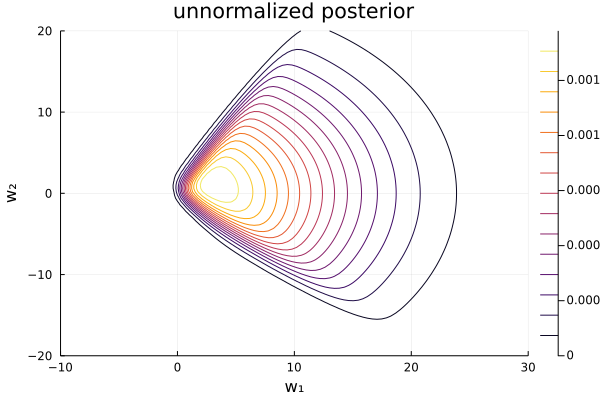

In [5]:
# 平均
μ_approx = w_seq[:, end]

# 共分散
hessian(w) = ForwardDiff.hessian(ulp, w)
Σ_approx = inv(-hessian(μ_approx))

# 分布を可視化する範囲
w₁s = range(-10, 30, length=100)
w₂s = range(-20, 20, length=100)

# 非正規化事後分布の可視化
contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) for w₁ in w₁s, w₂ in w₂s]', 
        xlab="w₁", ylab="w₂", title="unnormalized posterior")

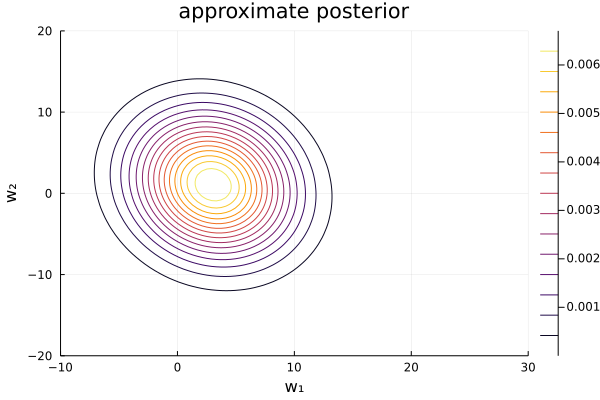

In [6]:
# 近似正規分布の可視化
contour(w₁s, w₂s, [pdf(MvNormal(μ_approx, Σ_approx), [w₁, w₂]) for w₁ in w₁s, w₂ in w₂s]',
                   xlab="w₁", ylab="w₂", title="approximate posterior", label=:none)

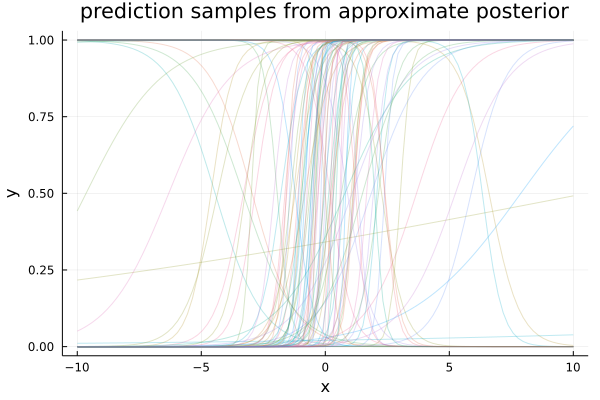

In [7]:
# 近似分布から候補のサンプルを100個抽出
W = rand(MvNormal(μ_approx, Σ_approx), 100)
p = plot(xlab="x", ylab="y", title="prediction samples from approximate posterior")
for i in 1:size(W,2)
    w₁, w₂ = W[:, i]
    f(x) = sig(w₁ * x + w₂)
    xs = range(-10, 10, length=100)
    p = plot!(xs, f.(xs), alpha=0.25, label=:none)
end
p

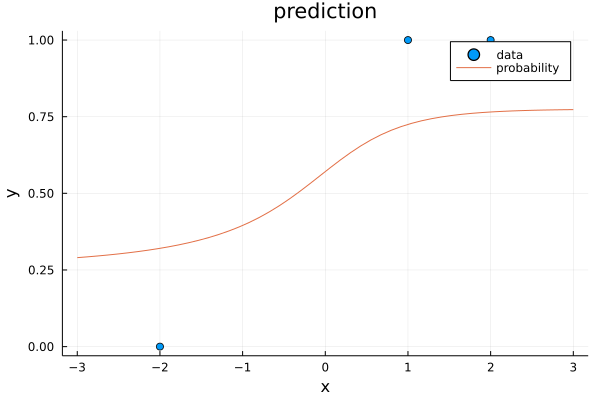

In [8]:
# 長方形の幅
Δ₁ = w₁s[2] - w₁s[1]
Δ₂ = w₂s[2] - w₂s[1]

# 積分近似による予測分布
p_predictive(x, y) = sum([pdf(Bernoulli(sig(w₁ * x + w₂)), y) * 
                          pdf(MvNormal(μ_approx, Σ_approx), [w₁, w₂]) *
                          Δ₁ * Δ₂ for w₁ in w₁s, w₂ in w₂s])

# 関数を可視化する範囲
xs = range(-3, 3, length=50)

scatter(X_obs, Y_obs, xlab="x", ylab="y", title="prediction", label="data")
plot!(xs, p_predictive.(xs, 1), label="probability")